# Deep Learning approach to the Boston Housing dataset - Autoencoder
## Team JARL

In [29]:
#import libraries and load data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras

from keras import regularizers, layers
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

data = pd.read_csv('boston_corrected.csv')
data = data.sample(frac=1).reset_index(drop=True)

train = data.iloc[:450,:]
test = data.iloc[450:,:]

# Drop undesired columns
rem = ['MEDV', 'CMEDV','TOWN','TOWNNO','TRACT']

raw_X_train = train.drop(rem, axis=1)
raw_Y_train = train['CMEDV']
raw_X_test = test.drop(rem, axis=1)
raw_Y_test = test['CMEDV']

# Set all column types to numeric
raw_X_train = np.asarray(raw_X_train).astype(np.float32)
raw_X_test = np.asarray(raw_X_test).astype(np.float32)
raw_Y_train = np.asarray(raw_Y_train).astype(np.float32)
raw_Y_test = np.asarray(raw_Y_test).astype(np.float32)

def Z_scoreNorm(data):
    column_mean = data.mean(axis=0)
    column_std = np.std(data, axis=0, dtype=float)
    Normalized_Inputs = (data - column_mean)/column_std
    
    return Normalized_Inputs

X_train = Z_scoreNorm(raw_X_train)
X_test = Z_scoreNorm(raw_X_test)
Y_train = Z_scoreNorm(raw_Y_train)
Y_test = Z_scoreNorm(raw_Y_test)

In [73]:
# Reality check
print(X_train.shape)
print(X_test.shape)

(450, 15)
(56, 15)


In [2]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=100,
    restore_best_weights=True,
)

In [33]:
choke = 10

autoencoder = Sequential([
    Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(choke, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(X_train.shape[1])
])

autoencoder.compile(optimizer=Adam(lr=0.01), 
                    loss='MSE', 
                    metrics=['mean_squared_error'])
checkpointer_a = ModelCheckpoint(filepath="AE.z1",
                               verbose=0,
                               save_best_only=True)
history_a = autoencoder.fit(X_train, X_train,
                    epochs=800,
                    batch_size=450,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[early_stopping, checkpointer_a]).history

Epoch 1/800
1/1 [==============================] - 1s 636ms/step - loss: 1.0087 - mean_squared_error: 1.0087 - val_loss: 0.9776 - val_mean_squared_error: 0.9776
INFO:tensorflow:Assets written to: AE.z1/assets
Epoch 2/800
1/1 [==============================] - 0s 41ms/step - loss: 0.9771 - mean_squared_error: 0.9771 - val_loss: 0.9524 - val_mean_squared_error: 0.9524
INFO:tensorflow:Assets written to: AE.z1/assets
Epoch 3/800
1/1 [==============================] - 0s 41ms/step - loss: 0.9589 - mean_squared_error: 0.9589 - val_loss: 0.9182 - val_mean_squared_error: 0.9182
INFO:tensorflow:Assets written to: AE.z1/assets
Epoch 4/800
1/1 [==============================] - 0s 40ms/step - loss: 0.9310 - mean_squared_error: 0.9310 - val_loss: 0.8737 - val_mean_squared_error: 0.8737
INFO:tensorflow:Assets written to: AE.z1/assets
Epoch 5/800
1/1 [==============================] - 0s 42ms/step - loss: 0.8881 - mean_squared_error: 0.8881 - val_loss: 0.8206 - val_mean_squared_error: 0.8206
INFO:te

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_34 (Dense)             (None, 20)                320       
_________________________________________________________________
dense_35 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_36 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_37 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_38 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_39 (Dense)             (None, 15)               

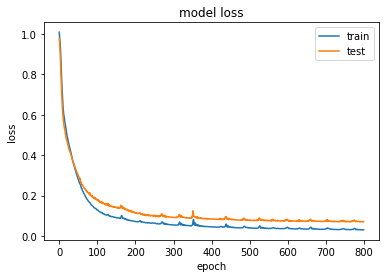

In [35]:
plt.plot(history_a['loss'])
plt.plot(history_a['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.savefig('losses_upstream.png', dpi=300)

autoencoder.summary()

In [36]:
# Reality check
a = 5
testinp = np.array(X_train[a,:]).reshape(1,X_train.shape[1])
y = autoencoder.predict(testinp)

print(np.array(X_train[a,:]))
print(y)

[-2.58394902 -0.56445661 -0.40192187  0.45684843 -0.79634822 -0.27668579
 -1.09522963  0.60459641 -1.84391573  1.97655124 -0.30547668 -0.47633576
  0.2947112   0.41283756 -0.85541114]
[[-2.5334818  -0.6174719  -0.34243667  0.41201037 -0.75701386 -0.34704125
  -1.269344    0.45172444 -1.940412    1.8250806  -0.38236898 -0.5003943
   0.36916667  0.26568413 -0.8145276 ]]


In [37]:
valuePredictor = Sequential([
    Dense(choke, activation='relu', input_shape=(choke,)),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1)
])

In [38]:
# Latent feature extraction
latent_model = Model(autoencoder.input, autoencoder.get_layer(index = 3).output )

latents_train = np.array([latent_model.predict(i.reshape(1, X_train.shape[1])) for i in X_train]).reshape(450, choke)
latents_test = np.array([latent_model.predict(i.reshape(1, X_train.shape[1])) for i in X_test]).reshape(56, choke)

valuePredictor.compile(optimizer=Adam(lr=0.03), 
                    loss='MSE', 
                    metrics=['mean_squared_error'])
checkpointer_1 = ModelCheckpoint(filepath="valuePredictor.z1",
                              verbose=0,
                              save_best_only=True)
history_1 = valuePredictor.fit(latents_train, Y_train,
                    epochs=700,
                    batch_size=450,
                    shuffle=True,
                    validation_data=(latents_test, Y_test),
                    verbose=1, callbacks=[early_stopping, checkpointer_1]).history

Epoch 1/700
1/1 [==============================] - 1s 598ms/step - loss: 1.2020 - mean_squared_error: 1.2020 - val_loss: 0.8948 - val_mean_squared_error: 0.8948
INFO:tensorflow:Assets written to: valuePredictor.z1/assets
Epoch 2/700
1/1 [==============================] - 0s 42ms/step - loss: 0.9251 - mean_squared_error: 0.9251 - val_loss: 0.9334 - val_mean_squared_error: 0.9334
Epoch 3/700
1/1 [==============================] - 0s 40ms/step - loss: 0.9508 - mean_squared_error: 0.9508 - val_loss: 0.7644 - val_mean_squared_error: 0.7644
INFO:tensorflow:Assets written to: valuePredictor.z1/assets
Epoch 4/700
1/1 [==============================] - 0s 40ms/step - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.7002 - val_mean_squared_error: 0.7002
INFO:tensorflow:Assets written to: valuePredictor.z1/assets
Epoch 5/700
1/1 [==============================] - 0s 39ms/step - loss: 0.7758 - mean_squared_error: 0.7758 - val_loss: 0.6755 - val_mean_squared_error: 0.6755
INFO:tensorflow:Ass

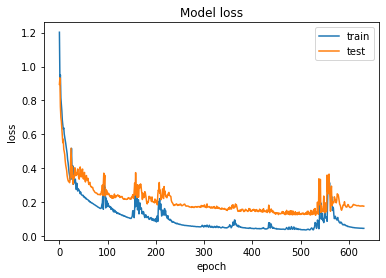

In [39]:
plt.plot(history_1['loss'])
plt.plot(history_1['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

plt.savefig('losses_downstream.png', dpi=300)

In [12]:
valuePredictor_baseline = Sequential([
    Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

In [ ]:
valuePredictor_baseline.compile(optimizer=Adam(lr=0.01), 
                    loss='MSE', 
                    metrics=['mean_squared_error'])
checkpointer_2 = ModelCheckpoint(filepath="valuePredictor_baseline.z1",
                              verbose=0,
                              save_best_only=True)
history_2 = valuePredictor_baseline.fit(X_train, Y_train,
                    epochs=700,
                    batch_size=450,
                    shuffle=True,
                    validation_data=(X_test, Y_test),
                    verbose=1, callbacks=[early_stopping, checkpointer_2]).history

In [40]:
# Test
ae_preds = np.zeros((56,))
base_preds = np.zeros((56,))
for i, record in enumerate(X_test):
  ae_preds[i] = valuePredictor.predict(latent_model.predict(np.array(record).reshape(1, X_train.shape[1])))
  base_preds[i] = valuePredictor_baseline.predict(np.array(record).reshape(1, X_train.shape[1]))


RMSE (Autoencoder): 0.2744064071115905
r2 (Autoencoder): 0.8768859250555621
RMSE (Baseline): 0.32389799729987445
r2 (Baseline): 0.83086722555883


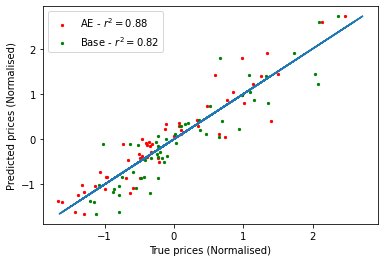

In [42]:
plt.scatter(ae_preds, Y_test, color='r', s=5, label='AE - $r^2 = 0.88$')
plt.scatter(base_preds, Y_test, color='g', s=5, label='Base - $r^2 = 0.83$')

plt.plot(Y_test,Y_test)
plt.xlabel("True prices (Normalised)")
plt.ylabel("Predicted prices (Normalised)")
plt.legend()
plt.savefig('predictions.png', dpi=300)

print("RMSE (Autoencoder):", np.sqrt((Y_test - ae_preds)**2).mean(axis=None))
print("r2 (Autoencoder):", r2_score(Y_test, ae_preds))

print("RMSE (Baseline):", np.sqrt((Y_test - base_preds)**2).mean(axis=None))
print("r2 (Baseline):", r2_score(Y_test, base_preds))